In [35]:
import torch
from torch import nn,optim
import torch.functional as D
from torchvision import datasets,transforms

### 接下来实现数据的预处理和fashion mnist的导入

In [36]:
trans=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
#使用transforms中函数把数据转化成totensor(张量）格式并用normalize进行标准化到-1到1，因为标准化后更好处理
#（权重在0附近）                                  ?疑问：为什么-1到1，书上是0到1

trainset=datasets.FashionMNIST('dataset/',train=True,transform=trans,download=True)
#导入数据集中的训练集，两个true可以看出，并用上面写的trans来进行处理
#疑问：后面download train transforms可以更换顺序吗？  尝试后发现可以

trainloader=torch.utils.data.DataLoader(trainset,batch_size=256,shuffle=True)
#构建训练机器人，每次随机（这样避免一直训练一个物品）从训练集中导入64张图片（据说叫minibatch训练法），
#这样训练速度相对更快更稳定


testset=datasets.FashionMNIST('dataset/',download=True,train=False,transform=trans)
#导入数据集中的测试集，train=False可以看出

testloader=torch.utils.data.DataLoader(testset,batch_size=256,shuffle=True)
#构建测试机器人，每次随机从测试集中导入64张图片

### 额外：用一下代码实现显示图片，（非任务要求，但是学了，所以想展示,而且可以表明导入成功）

 图片的标签是  运动鞋


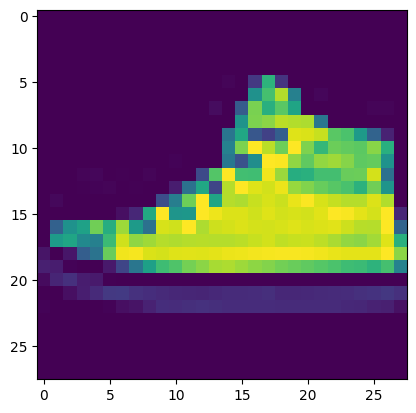

In [37]:
img,lab=next(iter(trainloader))
#使用迭代器iter导入trainloader中的数据，包含图片与标签

imgdemo=img[3]#导入数据集中为3的图片
imgdemolab=lab[3]#导入数据集中为3的标签（与上面一致）

imgdemo=imgdemo.reshape((28,28))  #y用reshape来去掉单通道的单改成28乘28像素格式

import matplotlib.pyplot as plt  #导入matplotlib中的图像函数
%matplotlib inline

plt.imshow(imgdemo)

lablist=['T恤','裤子','套衫','裙子','外套','凉鞋','汗衫','运动鞋','包包','靴子']
print(f' 图片的标签是  {lablist[imgdemolab]}')

## 接下来搭建并训练神经网络

In [38]:
from torch import nn, optim
import torch.nn.functional as D

class Classifier(nn.Module):#据我所学，这个类的继承属于是套公式照搬
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)#因为原本是28*28=784个，所以输入784
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,64)
        self.fc4 = nn.Linear(64,10)
        #这便是多层神经网络一点点传递，传递过程会减少，中间可更改，但是最终是10个
        #一个输入，一个输出，三个隐含
        
    def forward(self, x):
        # 定义正向传播的函数
        x = x.view(x.shape[0], -1)
        
        x = D.relu(self.fc1(x)) #relu函数用于修正线性单元函数，非线性激活，x<0时不传，>0时传递
        x = D.relu(self.fc2(x))
        x = D.relu(self.fc3(x))
        x = D.log_softmax(self.fc4(x), dim=1) #对数函数归一化
        
        return x

In [39]:
# 对上面定义的Classifier类进行实例化
model = Classifier()

# 定义损失函数为负对数损失函数
criterion = nn.NLLLoss()

# 优化方法为Adam梯度下降方法，学习率为0.003，此处Adam算法结合动量算法
optimizer = optim.Adam(model.parameters(), lr=0.003)

# 对训练集的全部数据学习15遍，这个数字越大，训练时间越长，根据所学，可以修改
epochs = 15

# 将每次训练的训练误差和测试误差存储在这两个列表里，后面绘制误差变化折线图用
train_losses, test_losses = [], []

print('开始训练')
for e in range(epochs):
    running_loss = 0
    
    # 对训练集中的所有图片都过一遍
    for images, labels in trainloader:
        # 将优化器中的求导结果都设为0，否则会在每次反向传播之后叠加之前的
        optimizer.zero_grad()
        
        # 对64张图片进行推断，计算损失函数，反向传播优化权重，将损失求和
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # 每次学完一遍数据集，都进行以下测试操作
    else:
        test_loss = 0
        accuracy = 0
        # 测试的时候不需要开自动求导和反向传播
        with torch.no_grad():
            
            
            # 对测试集中的所有图片都过一遍
            for images, labels in testloader:
                # 对传入的测试集图片进行正向推断、计算损失，accuracy为测试集一万张图片中模型预测正确率
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                # 等号右边为每一批64张测试图片中预测正确的占比
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        # 恢复Dropout
        model.train()
        # 将训练误差和测试误差存在两个列表里，后面绘制误差变化折线图用
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        
        #常用的字符串替换方式{}format
        print("训练集学习次数: {}/{}.. ".format(e+1, epochs),
              "训练误差: {:.3f}.. ".format(running_loss/len(trainloader)),
              "测试误差: {:.3f}.. ".format(test_loss/len(testloader)),
              "模型分类准确率: {:.3f}".format(accuracy/len(testloader)))

开始训练
训练集学习次数: 1/15..  训练误差: 0.541..  测试误差: 0.437..  模型分类准确率: 0.836
训练集学习次数: 2/15..  训练误差: 0.375..  测试误差: 0.407..  模型分类准确率: 0.852
训练集学习次数: 3/15..  训练误差: 0.336..  测试误差: 0.366..  模型分类准确率: 0.871
训练集学习次数: 4/15..  训练误差: 0.312..  测试误差: 0.371..  模型分类准确率: 0.863
训练集学习次数: 5/15..  训练误差: 0.291..  测试误差: 0.359..  模型分类准确率: 0.872
训练集学习次数: 6/15..  训练误差: 0.277..  测试误差: 0.350..  模型分类准确率: 0.874
训练集学习次数: 7/15..  训练误差: 0.261..  测试误差: 0.339..  模型分类准确率: 0.880
训练集学习次数: 8/15..  训练误差: 0.253..  测试误差: 0.351..  模型分类准确率: 0.875
训练集学习次数: 9/15..  训练误差: 0.242..  测试误差: 0.353..  模型分类准确率: 0.878
训练集学习次数: 10/15..  训练误差: 0.232..  测试误差: 0.367..  模型分类准确率: 0.872
训练集学习次数: 11/15..  训练误差: 0.221..  测试误差: 0.358..  模型分类准确率: 0.878
训练集学习次数: 12/15..  训练误差: 0.219..  测试误差: 0.355..  模型分类准确率: 0.883
训练集学习次数: 13/15..  训练误差: 0.211..  测试误差: 0.348..  模型分类准确率: 0.889
训练集学习次数: 14/15..  训练误差: 0.199..  测试误差: 0.358..  模型分类准确率: 0.884
训练集学习次数: 15/15..  训练误差: 0.188..  测试误差: 0.369..  模型分类准确率: 0.888


## 模型效果

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

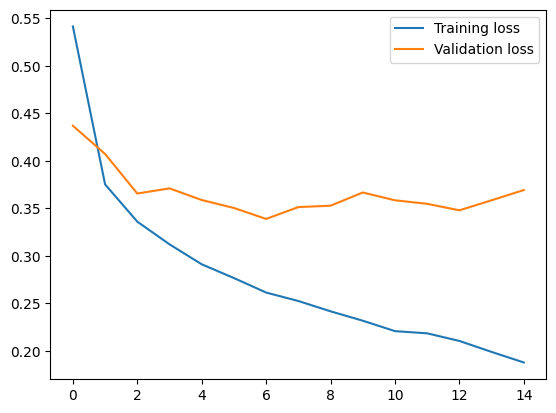

In [43]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()

神经网络猜测图片里是 套衫，概率为96.36635184288025%


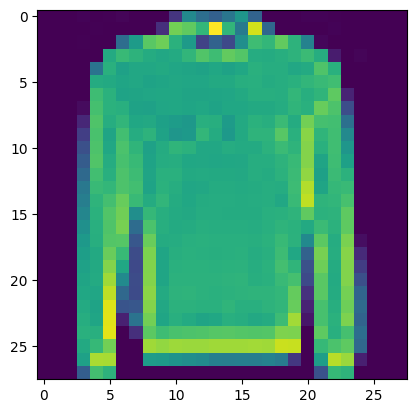

In [62]:
images, labels = next(iter(testloader))
img = images[0]
img = img.reshape((28,28)).numpy()
plt.imshow(img)

# 将测试图片转为一维的列向量
img = torch.from_numpy(img)
img = img.view(1, 784)

# 进行正向推断，预测图片所在的类别
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)

top_p, top_class = ps.topk(1, dim=1)
labellist = ['T恤','裤子','套衫','裙子','外套','凉鞋','汗衫','运动鞋','包包','靴子']
prediction = labellist[top_class]
probability = float(top_p)
print(f'神经网络猜测图片里是 {prediction}，概率为{probability*100}%')

# DAY4任务

## 问题一：层数与每一层的维度对训练结果的影响

首先查找网络上关于层数对神经网络学习的影响，得到以下答案：
深度学习神经网络的层数对学习有一定的影响。增加神经网络的层数可以增加模型的表达能力，使其能够学习更复杂的特征和模式。然而，如果层数过多，可能会出现梯度消失或梯度爆炸的问题，导致训练困难或不稳定。因此，选择适当的网络层数对于模型的性能是非常重要的

### 层次3，维度？

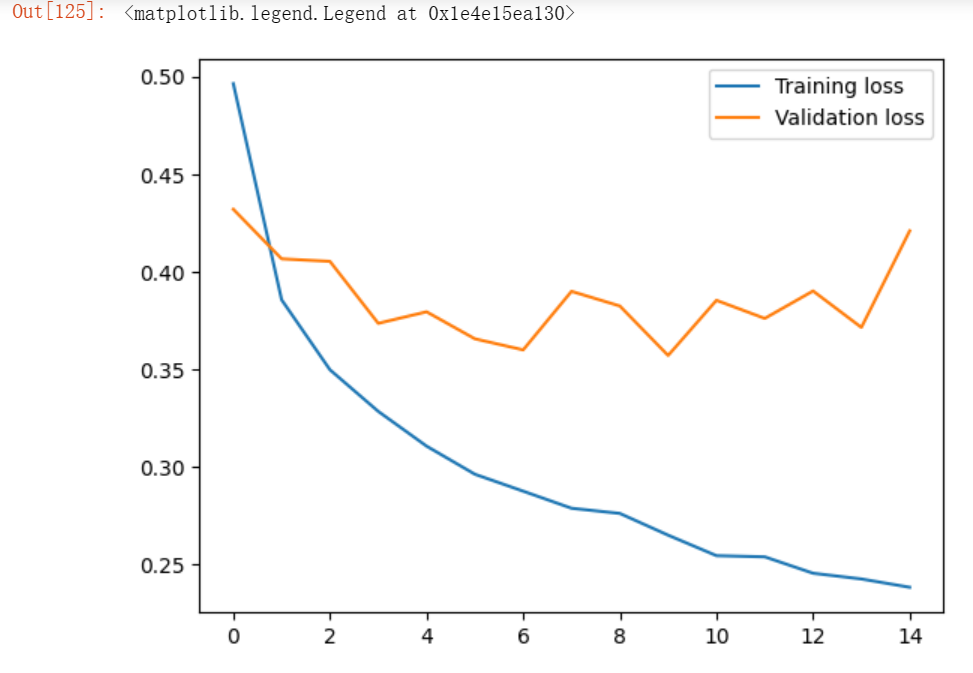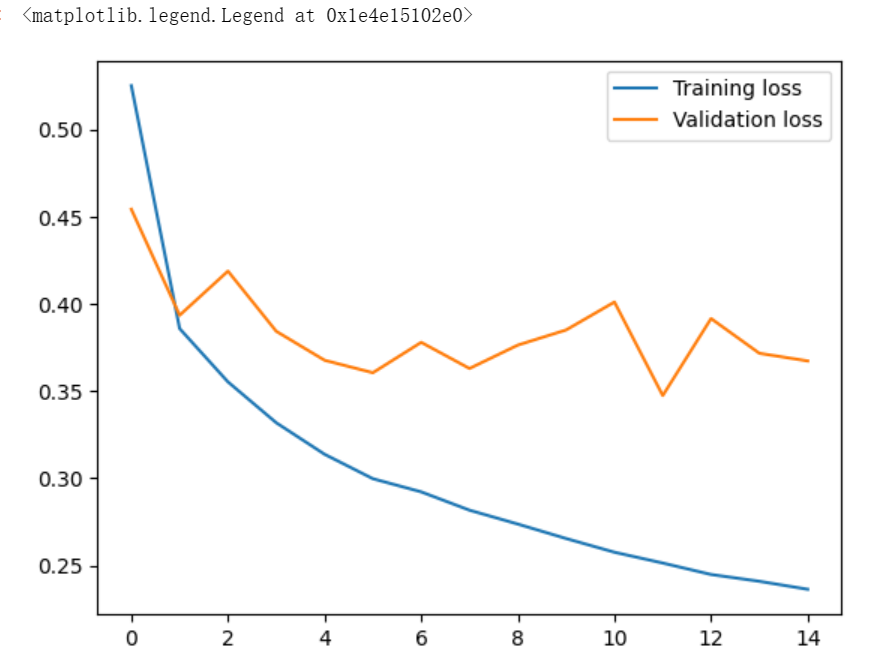

### 层数4，维度？训练结果

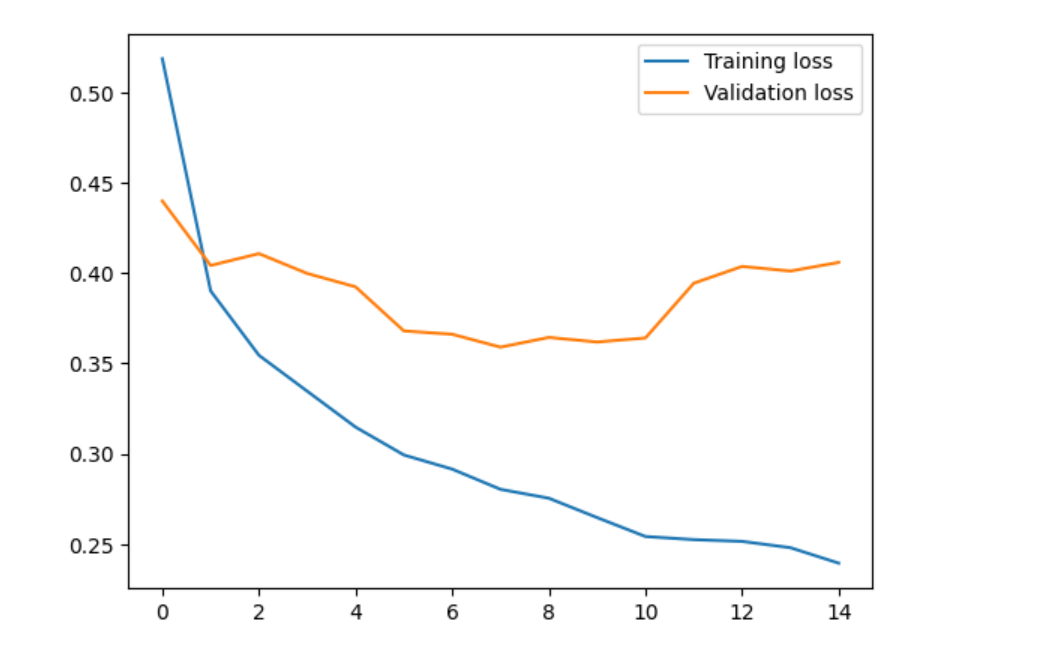

### 层数5，维度？训练结果

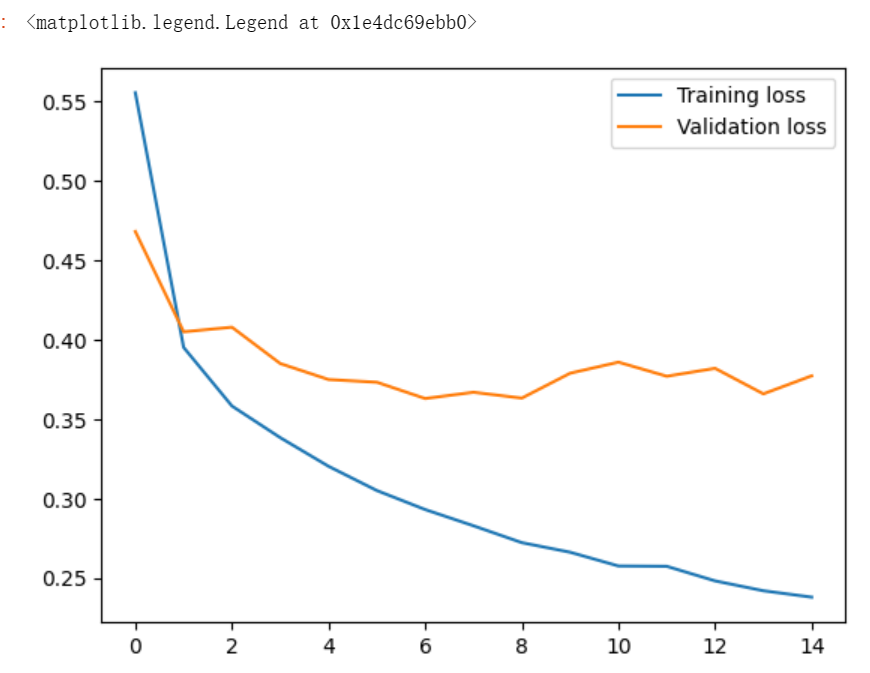

### 层数7，维度？

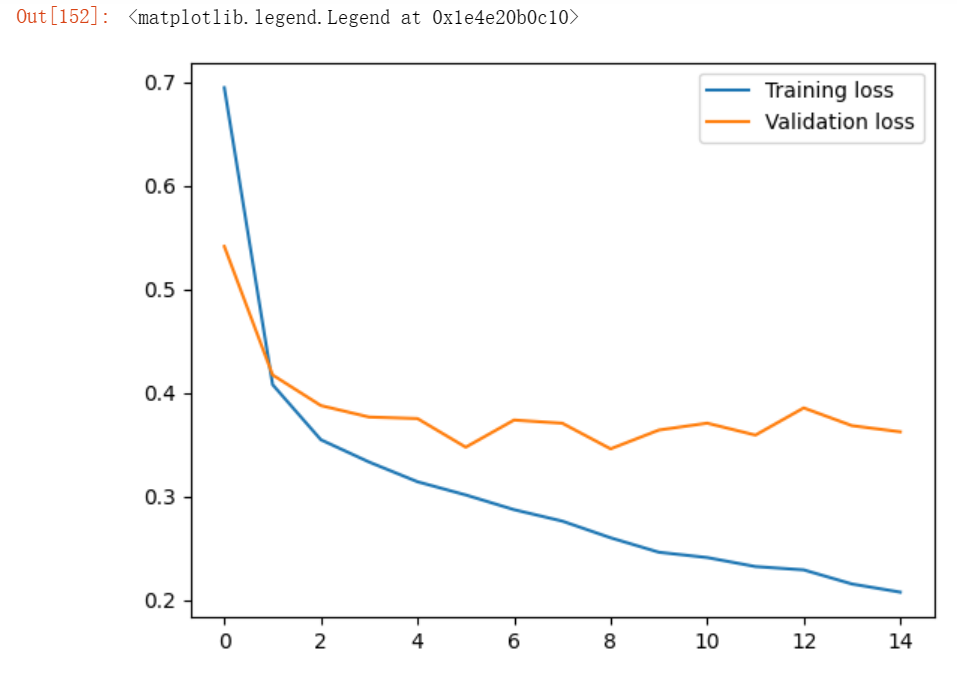

### 由如上图所见，在一定范围内，学习层数的增加会使学习更加稳定，但同时使得错误率下降的梯度变小，导致学习的错误率难以下降，但整体来看学习错误率的影响不大，可能是自然出现的随机误差；而训练误差明显在随着层数的增加而下降，推测出现过拟合现象。

# 问题二：训练轮数对学习的影响

此问题看起来可以直接由原本的训练图像中看出：最开时的训练中，随着训练轮数的增加，测试错误先稳定下降，然后开始产生波动，其中6到10次的训练误差最小。所以我觉得训练轮数是6到10次均是合适的。接下来我在模拟两次训练，得到训练图像，通过同样的条件下得到的三次图像来判断我的结论是否正确

### 第一次训练

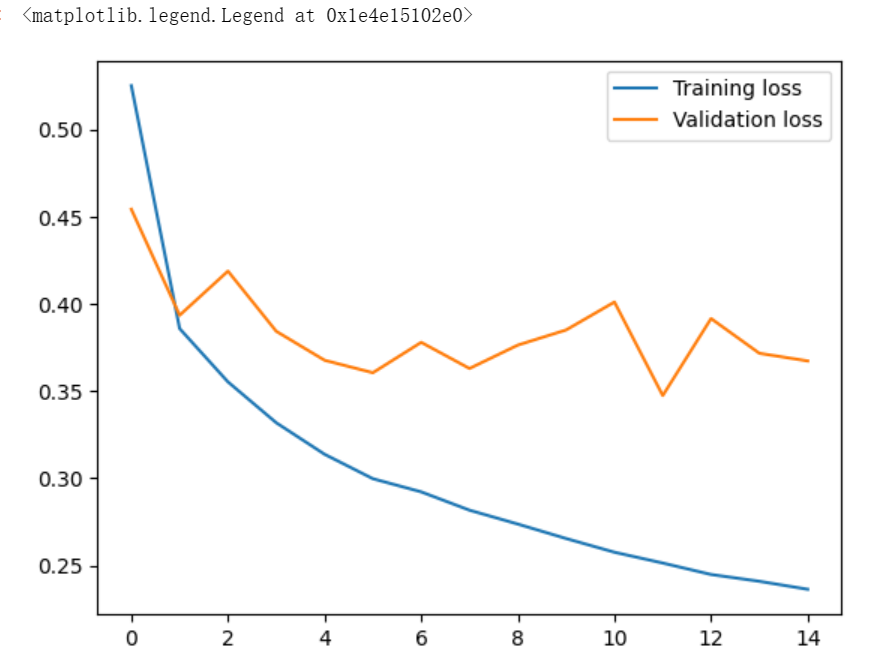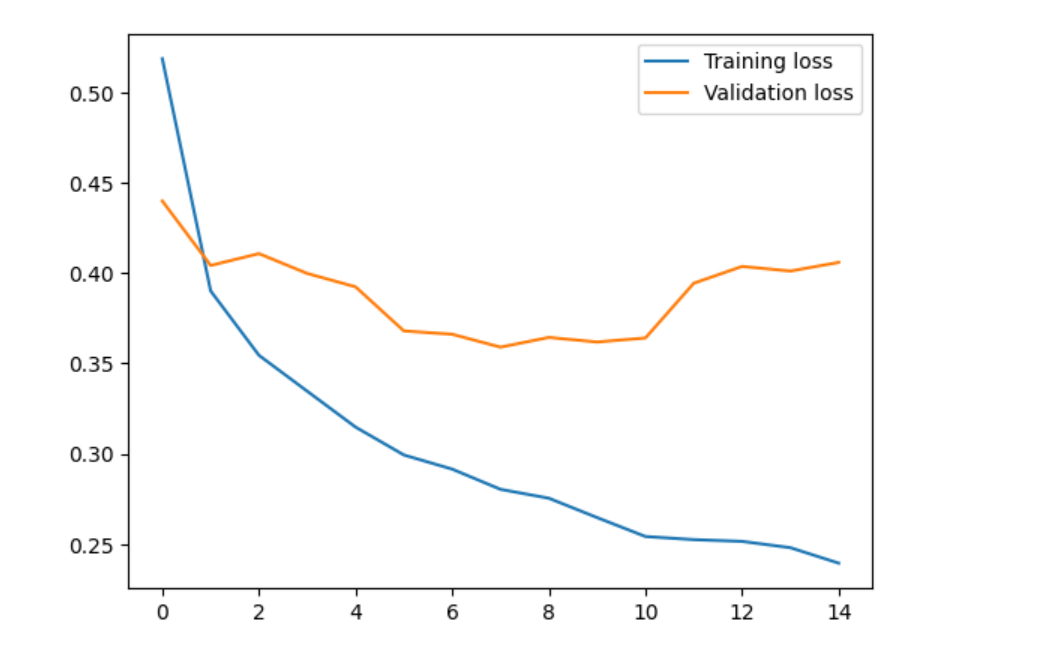

### 第二次训练

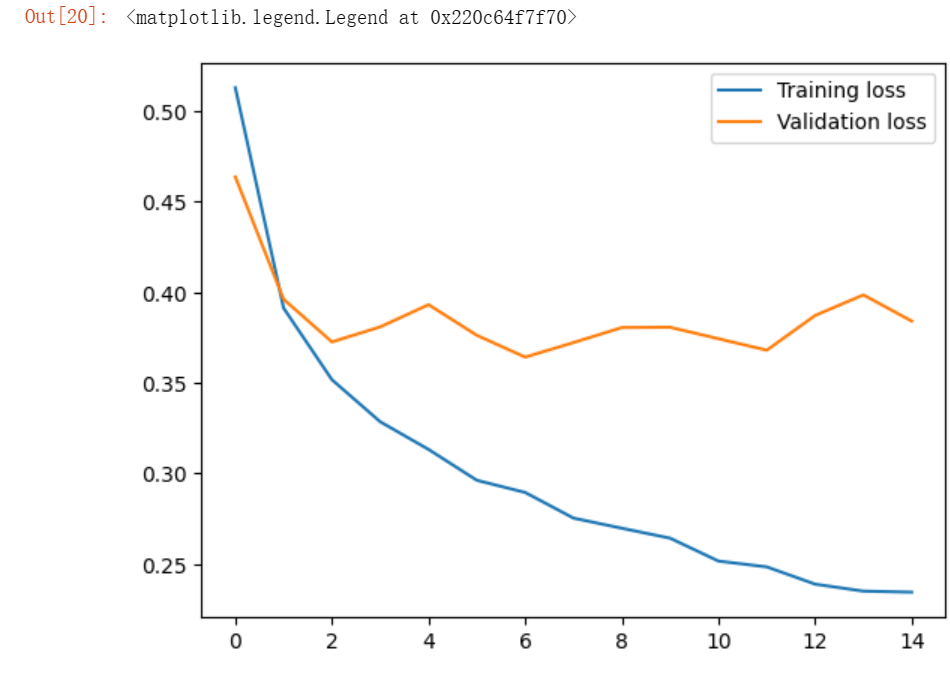

## 第三次训练结果：

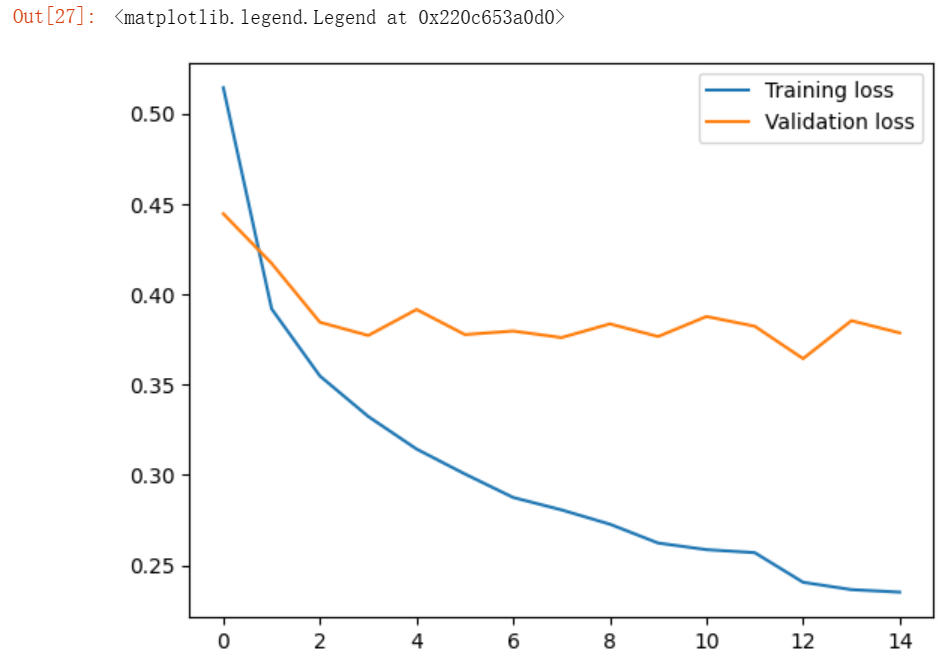

由上三图可见，三个图像的测试曲线有所不同，但是大致均在第6次左右达到最低误差，所以大概可以在第6次或第七次停止训练最为合适

# 由于篇幅过长，剩余问题在“算法作业2”中得到解答